In [329]:
%load_ext autoreload
import os, os.path
from utils import *
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!ls

analysis.ipynb            job.slumr                 yolo-mixed_test.out
best.pt                   job.slurm                 yolo_loss_copy.py
data_setup.ipynb          roadcrack.yaml            yolo_preds
data_setup_local.ipynb    utils.py                  yolov7
detect.slurm              yolo-mixed.out            yolov7_big_prediction.out


In [126]:
%cd yolov7
!pip install -r requirements.txt
%cd ..

[Errno 2] No such file or directory: 'yolov7'
/Users/vnilsen/Documents/Informatikk master/Visual Intelligence/miniproject/roadcrack-detection/yolov7_notebooks/yolov7
You should consider upgrading via the '/Users/vnilsen/Documents/Informatikk master/Visual Intelligence/miniproject/roadcrack-detection/venv/bin/python -m pip install --upgrade pip' command.
/Users/vnilsen/Documents/Informatikk master/Visual Intelligence/miniproject/roadcrack-detection/yolov7_notebooks


# Add empty file for images with no bbox and save all to dic

In [99]:
%autoreload
# must be at ./yolov7_notebooks to run
dic_test_labels = get_dic(txt_path='yolo_preds/labels', img_path='../datasets/Norway/test/images', mode='preds')
dic_val = get_dic(txt_path= 'yolov7/custom_dataset/val/labels', img_path='yolov7/custom_dataset/val/labels', mode='not_preds')
dic_train = get_dic(txt_path= 'yolov7/custom_dataset/train/labels', img_path='yolov7/custom_dataset/train/labels', mode='not_preds')

In [100]:
print(dic_test_labels["Norway_008680.txt"])

[[0, '0.27401', '0.556511', '0.00495049', '0.012285', 0.36084], [0, '0.244431', '0.803685', '0.014604', '0.0624079', 0.854004]]


In [101]:
print(dic_val['Norway_000032.txt'])

[[1, '0.2930277244029646', '0.7258696717295443', '0.146856986000549', '0.016168544830965213']]


In [102]:
print(dic_train['Norway_000000.txt'])

[[0, '0.31602739726027396', '0.6401663405088063', '0.008493150684931507', '0.026908023483365948\n'], [3, '0.4336986301369863', '0.5817025440313112', '0.025205479452054796', '0.05675146771037182\n'], [0, '0.49794520547945204', '0.9449608610567515', '0.024383561643835615', '0.10420743639921722\n'], [0, '0.4401369863013699', '0.6455479452054794', '0.009589041095890411', '0.02299412915851272\n'], [0, '0.4156164383561644', '0.6042074363992173', '0.005479452054794521', '0.018590998043052837']]


In [109]:
!ls yolov7

LICENSE.md           hubconf.py           train.py
README.md            inference            train_aux.py
__pycache__          models               utils
cfg                  paper                yolov7.pt
custom_dataset       requirements.txt     yolov7_training.pt
data                 runs                 yolov7_training.pt.1
deploy               scripts              yolov7_training.pt.2
detect.py            test.py              yolov7_training.pt.3
export.py            tools
figure               traced_model.pt


In [133]:
%cd yolov7
!python3.9 detect.py --weights runs/train/yolov7_multi_gpu_big/weights/best.pt --conf 0.1 --img-size 1216 --source custom_dataset/val/images --name predictions --save-txt --device CPU --save-conf

[Errno 2] No such file or directory: 'yolov7'
/Users/vnilsen/Documents/Informatikk master/Visual Intelligence/miniproject/roadcrack-detection/yolov7_notebooks/yolov7
Namespace(weights=['runs/train/yolov7_multi_gpu_big/weights/best.pt'], source='custom_dataset/val/images', img_size=1216, conf_thres=0.1, iou_thres=0.45, device='CPU', view_img=False, save_txt=True, save_conf=True, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='predictions', exist_ok=False, no_trace=False)
YOLOR 🚀 2022-11-23 torch 1.10.0 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Sum

In [333]:
!ls
#%cd ..

__pycache__               job.slumr                 yolo-mixed.out
analysis.ipynb            job.slurm                 yolo-mixed_test.out
data_setup.ipynb          roadcrack.yaml            yolo_preds
data_setup_local.ipynb    runs                      yolov7
detect.slurm              utils.py                  yolov7_big_prediction.out


In [334]:
# assumed to be in folder /yolov7_notebooks/

dic_test_labels = get_dic(txt_path='yolo_preds/labels', img_path='../datasets/Norway/test/images', mode='preds')

from PIL import Image

def upscale_bbox_coordinates(id, yolo_bbox):

    with Image.open('../datasets/Norway/test/images/'+id+'.jpg') as im:
        w, h = im.size

    # top left corner
    #xmin = int(w*float(arr[1]))
    #ymin = int(h*float(arr[2]))

    # scale bbox by h and w
    #xmax = int(xmin + w*float(arr[3]))
    #ymax = int(ymin + h*float(arr[4]))

    x_center_n, y_center_n = float(yolo_bbox[1]), float(yolo_bbox[2])
    box_w_n, box_h_n       = float(yolo_bbox[3]), float(yolo_bbox[4])

    x_center = int(x_center_n*w)
    y_center = int(y_center_n*h)

    box_w = int(box_w_n*w)
    box_h = int(box_h_n*h)

    xmin = x_center - box_w//2
    xmax = x_center + box_w//2
    ymin = y_center - box_h//2
    ymax = y_center + box_h//2

    return xmin, ymin, xmax, ymax

def create_string(id):
    arr = dic_test_labels[id+'.txt']
    string = ""
    # go through array of arrays
    # format [[label, x_top_left, y_top_left, width, height, conf],[label, x_top_left, y_top_left, width, height, conf]]
    for pred in sorted(arr, key=lambda x: x[-1], reverse=True)[:5]: #choose top 5 based on confidence
        if pred and pred[-1] > 0.85: # list not empty and above conf
            pred[0] += 1 # make sure range of classes is [1,4]
            #if pred[0] == 3:
            #    pred[0] = 4
            #elif pred[0] == 4:
            #    pred[0] = 3
            #else:
            #    pass # not 3 or 4
            pred[1], pred[2], pred[3], pred[4] = upscale_bbox_coordinates(id, pred)

            string += " ".join(str(s) for s in pred[:-1])
            string += ' '
    return str(string[:-1])

submission = pd.DataFrame()
submission['ImageId'] = dic_test_labels.keys()

submission['ImageId'] = submission["ImageId"].apply(lambda x: str(x[:-4]))

submission['PredictionString'] = ''
submission['PredictionString'] = submission['ImageId'].apply(lambda x: create_string(x))
submission['ImageId'] = submission["ImageId"].apply(lambda x: x+'.jpg')
#print(submission['ImageId'])
submission = submission.sort_values(by=['ImageId'])
submission

0       Norway_010108.jpg
1       Norway_008747.jpg
2       Norway_009459.jpg
3       Norway_008753.jpg
4       Norway_010134.jpg
              ...        
2035    Norway_009332.jpg
2036    Norway_009326.jpg
2037    Norway_008986.jpg
2038    Norway_009440.jpg
2039    Norway_010111.jpg
Name: ImageId, Length: 2040, dtype: object


,ImageId,PredictionString
1597,Norway_008161.jpg,1 1586 1474 1708 2034
1733,Norway_008162.jpg,
1699,Norway_008163.jpg,1 484 1609 622 1731 1 1302 1503 1524 2029 1 13...
1980,Norway_008164.jpg,
1968,Norway_008165.jpg,
...,...,...
754,Norway_010196.jpg,
657,Norway_010197.jpg,
1413,Norway_010198.jpg,
1506,Norway_010199.jpg,


In [335]:
submission.to_csv('submission_norway_1.csv', index=False, header=None, sep=',')

<BarContainer object of 5 artists>

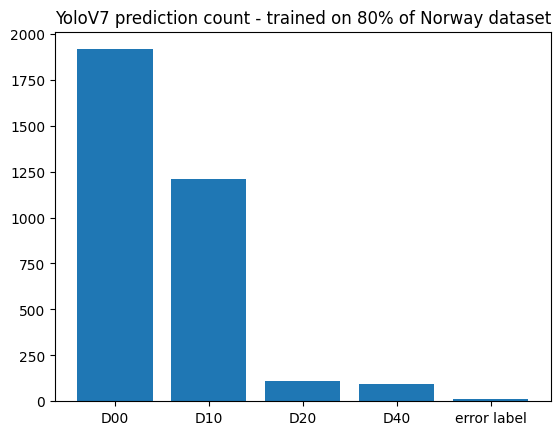

In [363]:
class_counts = {'0':0, '1':0, '2':0, '3':0, '4':0}
names = ['D00', 'D10', 'D20', 'D40', "error label"]
for entry in dic_test_labels.values():
    if entry: # has prediction(s)
        for arr in entry:
            class_counts[str(arr[0])] += 1
plt.title('YoloV7 prediction count - trained on 80% of Norway dataset')
plt.bar(names, class_counts.values())

In [351]:
dic_train = get_dic(txt_path= 'yolov7/custom_dataset/train/labels', img_path='yolov7/custom_dataset/train/labels', mode='not_preds')

<BarContainer object of 4 artists>

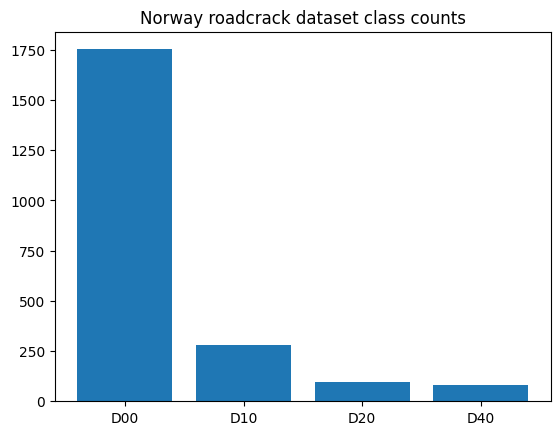

In [365]:
class_counts = {'0':0, '1':0, '2':0, '3':0}
names = ['D00', 'D10', 'D20', 'D40']
for entry in dic_train.values():
    if entry: # has prediction(s)
        for arr in entry:
            class_counts[str(arr[0])] += 1

plt.title('Norway roadcrack dataset class counts')
plt.bar(names, class_counts.values())